In [186]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Flatten , InputLayer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
import tensorflow as tf

In [63]:
dataset, dataset_info = tfds.load('malaria',
                                  with_info = True,
                                  as_supervised= True,
                                  shuffle_files= True,
                                  split=['train'])

In [174]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

In [75]:
dataset = dataset[0]

In [145]:
def split_dataset(dataset  , train_size , test_size ,val_size = 0):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(DATASET_SIZE*train_size))
  test_dataset = dataset.skip(int(DATASET_SIZE*train_size)).take(int(DATASET_SIZE*test_size))
  val_dataset = dataset.skip(int(DATASET_SIZE*train_size)).skip(int(DATASET_SIZE*test_size))
  return train_dataset, test_dataset ,val_dataset

In [146]:
lists = [10,10,3 ,4,5,6,8,9,0,14]
DATASET_SIZE = len(dataset)
TRAIN_RATIO =0.8
TEST_RATIO =0.1
VAL_RATIO =0.1

In [147]:
DATASET_SIZE

27558

In [159]:
train_dataset, test_dataset ,val_dataset = split_dataset(dataset  , TRAIN_RATIO , TEST_RATIO ,VAL_RATIO)

In [150]:
len(test_dataset)

2755

In [160]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [161]:
train_dataset.take(1).as_numpy_iterator()

In [157]:
list_train = list(train_dataset.take(1).as_numpy_iterator())

In [158]:
list_train

[(array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8),
  1)]

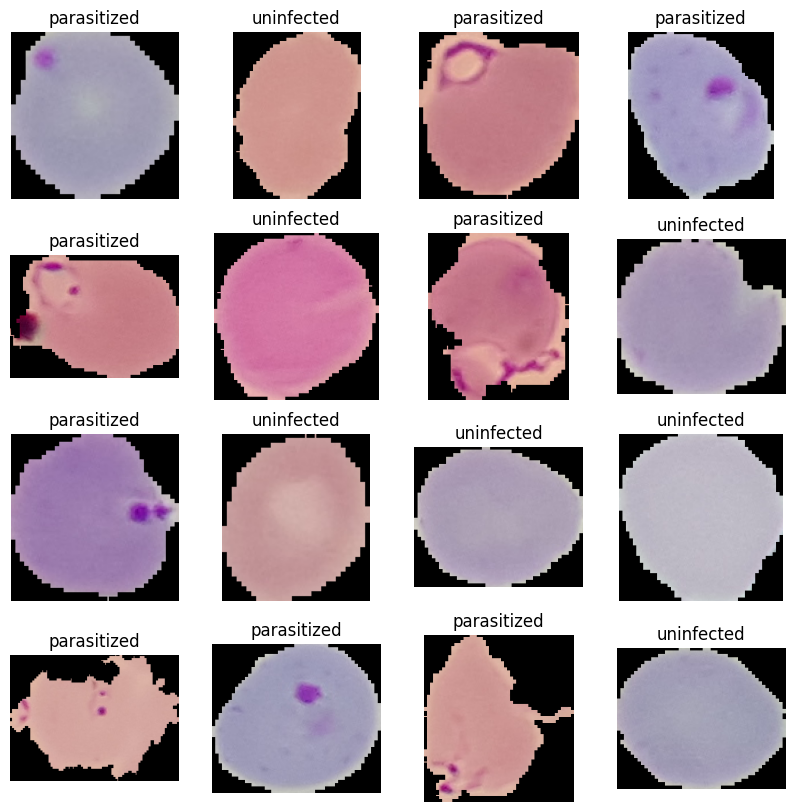

In [171]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [172]:
IMAGE_SIZE = 224

In [177]:
def image_resize_normalize (image , label ) :
  image = tf.image.resize(image , (IMAGE_SIZE ,IMAGE_SIZE)) /255
  return image , label

In [178]:
train_dataset =  train_dataset.map(image_resize_normalize)
test_dataset =  test_dataset.map(image_resize_normalize)
val_dataset = val_dataset.map(image_resize_normalize)

In [182]:
for data in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(124, 148, 3), dtype=uint8) tf.Tensor(1, shape=(), dtype=int64)


In [183]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [185]:
val_dataset = val_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [189]:
model = Sequential([
    InputLayer(input_shape =(IMAGE_SIZE ,IMAGE_SIZE,3)),
    Conv2D(filters = 6 ,kernel_size= 6 ,padding ='valid' , activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2) , strides=2),


     Conv2D(filters = 16 ,kernel_size= 3 ,padding ='valid' , activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2) , strides=2),

    Flatten(),
    Dense(100 , activation = 'relu'),
    BatchNormalization(),

    Dense(10 , activation = 'relu'),
    BatchNormalization(),

    Dense(1 , activation = 'sigmoid'),



])

In [190]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 219, 219, 6)       654       
                                                                 
 batch_normalization_2 (Bat  (None, 219, 219, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 109, 109, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 107, 107, 16)      880       
                                                                 
 batch_normalization_3 (Bat  (None, 107, 107, 16)      64        
 chNormalization)                                                
                                                      

In [191]:
model.compile(optimizer = Adam(learning_rate= 0.01),
loss = BinaryCrossentropy(),
              metrics='accuracy',
              )

In [ ]:
history = model.fit(train_dataset , validation_data=val_dataset ,epochs=100 , verbose = 1)

Epoch 1/100
689/689 [==============================] - 54s 67ms/step - loss: 0.5141 - accuracy: 0.7389 - val_loss: 5.8554 - val_accuracy: 0.5245
Epoch 2/100
689/689 [==============================] - 43s 63ms/step - loss: 0.2252 - accuracy: 0.9199 - val_loss: 0.5027 - val_accuracy: 0.6126
Epoch 3/100
689/689 [==============================] - 51s 74ms/step - loss: 0.1917 - accuracy: 0.9348 - val_loss: 0.2424 - val_accuracy: 0.9264
Epoch 4/100
689/689 [==============================] - 44s 64ms/step - loss: 0.1737 - accuracy: 0.9417 - val_loss: 0.2686 - val_accuracy: 0.9180
Epoch 5/100
689/689 [==============================] - 50s 73ms/step - loss: 0.1536 - accuracy: 0.9494 - val_loss: 0.7179 - val_accuracy: 0.8422
Epoch 6/100
689/689 [==============================] - 50s 73ms/step - loss: 0.1383 - accuracy: 0.9545 - val_loss: 0.4415 - val_accuracy: 0.9369
Epoch 7/100
689/689 [==============================] - 50s 73ms/step - loss: 0.1287 - accuracy: 0.9567 - val_loss: 0.3545 - val_ac

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
model.evaluate(test_dataset)


In [ ]:
def paraside_or_not(x):
  if(x < 0.5):
    return str('P')
  else:
    return str('U')

In [ ]:

for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(paraside_or_not(label.numpy()[0])) + ":" +str(paraside_or_not(model.predict(image)[0][0])))
  plt.axis('off')